In [17]:
import pandas as pd
import os
import sys
import numpy as np
import ast
import geopandas as gpd
import re
import math
import copy

from urllib.request import urlopen
from zipfile import ZipFile

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.dates import MonthLocator, DateFormatter

import requests
from io import StringIO
from shapely.geometry import Point

from matplotlib_scalebar.scalebar import ScaleBar


import matplotlib as mpl
import glob

import glob
import seaborn as sb
sb.set(style='whitegrid', palette='pastel', color_codes=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE + 4)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE + 4)  # fontsize of the figure title


pd.set_option('display.max_columns', 0)  # show all columns
pd.options.display.max_colwidth = 100


import glob
import seaborn as sb
pd.set_option('mode.chained_assignment', None)
sb.set(style='whitegrid', palette='pastel', color_codes=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE + 4)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE + 4)  # fontsize of the figure title


pd.set_option('display.max_columns', 0)  # show all columns
pd.options.display.max_colwidth = 100

pd.set_option('mode.chained_assignment', None)

In [18]:
# monthly_files = glob(os.path.join(data_dir, r'sampling_rates_*_monthly.csv'))
# monthly_files

# save_dir = r'/content/drive/Shareddrives/T5/safegraph_bias/figures'
# data_dir = r'/content/drive/Shareddrives/T5/safegraph_bias'

# save_dir = r'P:\Shared drives\T5\safegraph_bias\figures'
# data_dir = r'P:\Shared drives\T5\safegraph_bias'
# data_dir = r'P:\Shared drives\T5\safegraph_bias\refined_20230309'
# save_dir = r'P:\Shared drives\T5\safegraph_bias\refined_20230309\figures'

data_dir = r'F:\Research\Safegraph_bias\20230916'
save_dir = r'F:\Research\Safegraph_bias\figures_20230917'


urban_rural_county_xls = os.path.join(data_dir, 'ruralurbancodes2013.xls')
urban_rural_county_df = pd.read_excel(urban_rural_county_xls, dtype={'FIPS':str})
# add the urban column
urban_rural_county_df['Urban'] = urban_rural_county_df['Description'].str[:5].replace({'Metro': 'Yes', 'Nonme': 'No'})


urban_rural_tract_csv = os.path.join(data_dir, 'FoodAccessResearchAtlasData2019.csv')
urban_rural_tract_df = pd.read_csv(urban_rural_tract_csv, dtype={'fips':str}, encoding='UTF-8')
# clean data
urban_rural_tract_df['FIPS'] = urban_rural_tract_df['fips'].astype(str).str.zfill(11)
urban_rural_tract_df['Urban'] = urban_rural_tract_df['Urban'].replace({1:'Yes', 0:'No'})

urban_rural_cbg_csv = os.path.join(data_dir, 'CBG_urbanization_2type_2019.csv')
urban_rural_cbg_df = pd.read_csv(urban_rural_cbg_csv, dtype={'CBG_FIPS':str})
urban_rural_cbg_df['FIPS'] = urban_rural_cbg_df['CBG_FIPS'] 

# store in a dict
urban_df_dict = {'county':urban_rural_county_df, 'tract':urban_rural_tract_df, 'CBG':urban_rural_cbg_df}
urban_df_dict['CBG'].sample(5)

,CBG_FIPS,area_ratio,Urban,GEOID_data,FIPS
40632,121030275021,1.0,Yes,15000US121030275021,121030275021
94574,360274100002,1.0,Yes,15000US360274100002,360274100002
137287,482014105001,1.0,Yes,15000US482014105001,482014105001
157428,010439647002,1.0,No,15000US010439647002,010439647002
51970,170978630041,1.0,Yes,15000US170978630041,170978630041


In [19]:
years = [2019, 2018, 2020, 2021, 2022]


data_dict = {}
df_list = []
for year in years:
    csv_file = os.path.join(data_dir, f'sampling_rates_{year}_monthly.csv')
    try:
        df = pd.read_csv(csv_file, dtype={'fips':str})
    except:
        df = pd.read_csv(csv_file, dtype={'fips':str}, encoding='utf-16') 
    df['start_date'] = pd.to_datetime(df['start_date'], format='%Y%m')
    df['county_FIPS'] = df['fips'].str[:5]
    df['fips_level'] = df['fips_level'].replace({'cbg':"CBG"})
    df_list.append(df)
    data_dict[year] = df

data_dict[2021].sample(5) 

,start_date,end_date,CBG_count,fips,device_count,population,year,aggre_column_value,sampling_rate,fips_len,fips_level,county_FIPS
778193,2021-11-01,202111,2,06037462202,103,2775,2021,6037462202,0.037117,11,tract,06037
1017114,2021-01-01,202101,1,260992257021,60,663,2021,260992257021,0.090498,12,CBG,26099
1094254,2021-01-01,202101,1,450439205011,285,4293,2021,450439205011,0.066387,12,CBG,45043
2158973,2021-06-01,202106,1,370810126013,47,686,2021,370810126013,0.068513,12,CBG,37081
2324141,2021-07-01,202107,1,250056401005,49,1604,2021,250056401005,0.030549,12,CBG,25005


2019 len of df: 3549068
0
Level: state len of level_df: 592
1
Level: county len of level_df: 36569
2
Level: tract len of level_df: 785178
3
Level: CBG len of level_df: 2363816
2018 len of df: 3548981
0
Level: state len of level_df: 592
1
Level: county len of level_df: 36650
2
Level: tract len of level_df: 807236
3
Level: CBG len of level_df: 2407533
2020 len of df: 3549036
0
Level: state len of level_df: 592
1
Level: county len of level_df: 36607
2
Level: tract len of level_df: 797053
3
Level: CBG len of level_df: 2380973
2021 len of df: 3546880
0
Level: state len of level_df: 592
1
Level: county len of level_df: 36672
2
Level: tract len of level_df: 799211
3
Level: CBG len of level_df: 2384692
2022 len of df: 3548718
0
Level: state len of level_df: 565
1
Level: county len of level_df: 33022
2
Level: tract len of level_df: 740730
3
Level: CBG len of level_df: 2215013


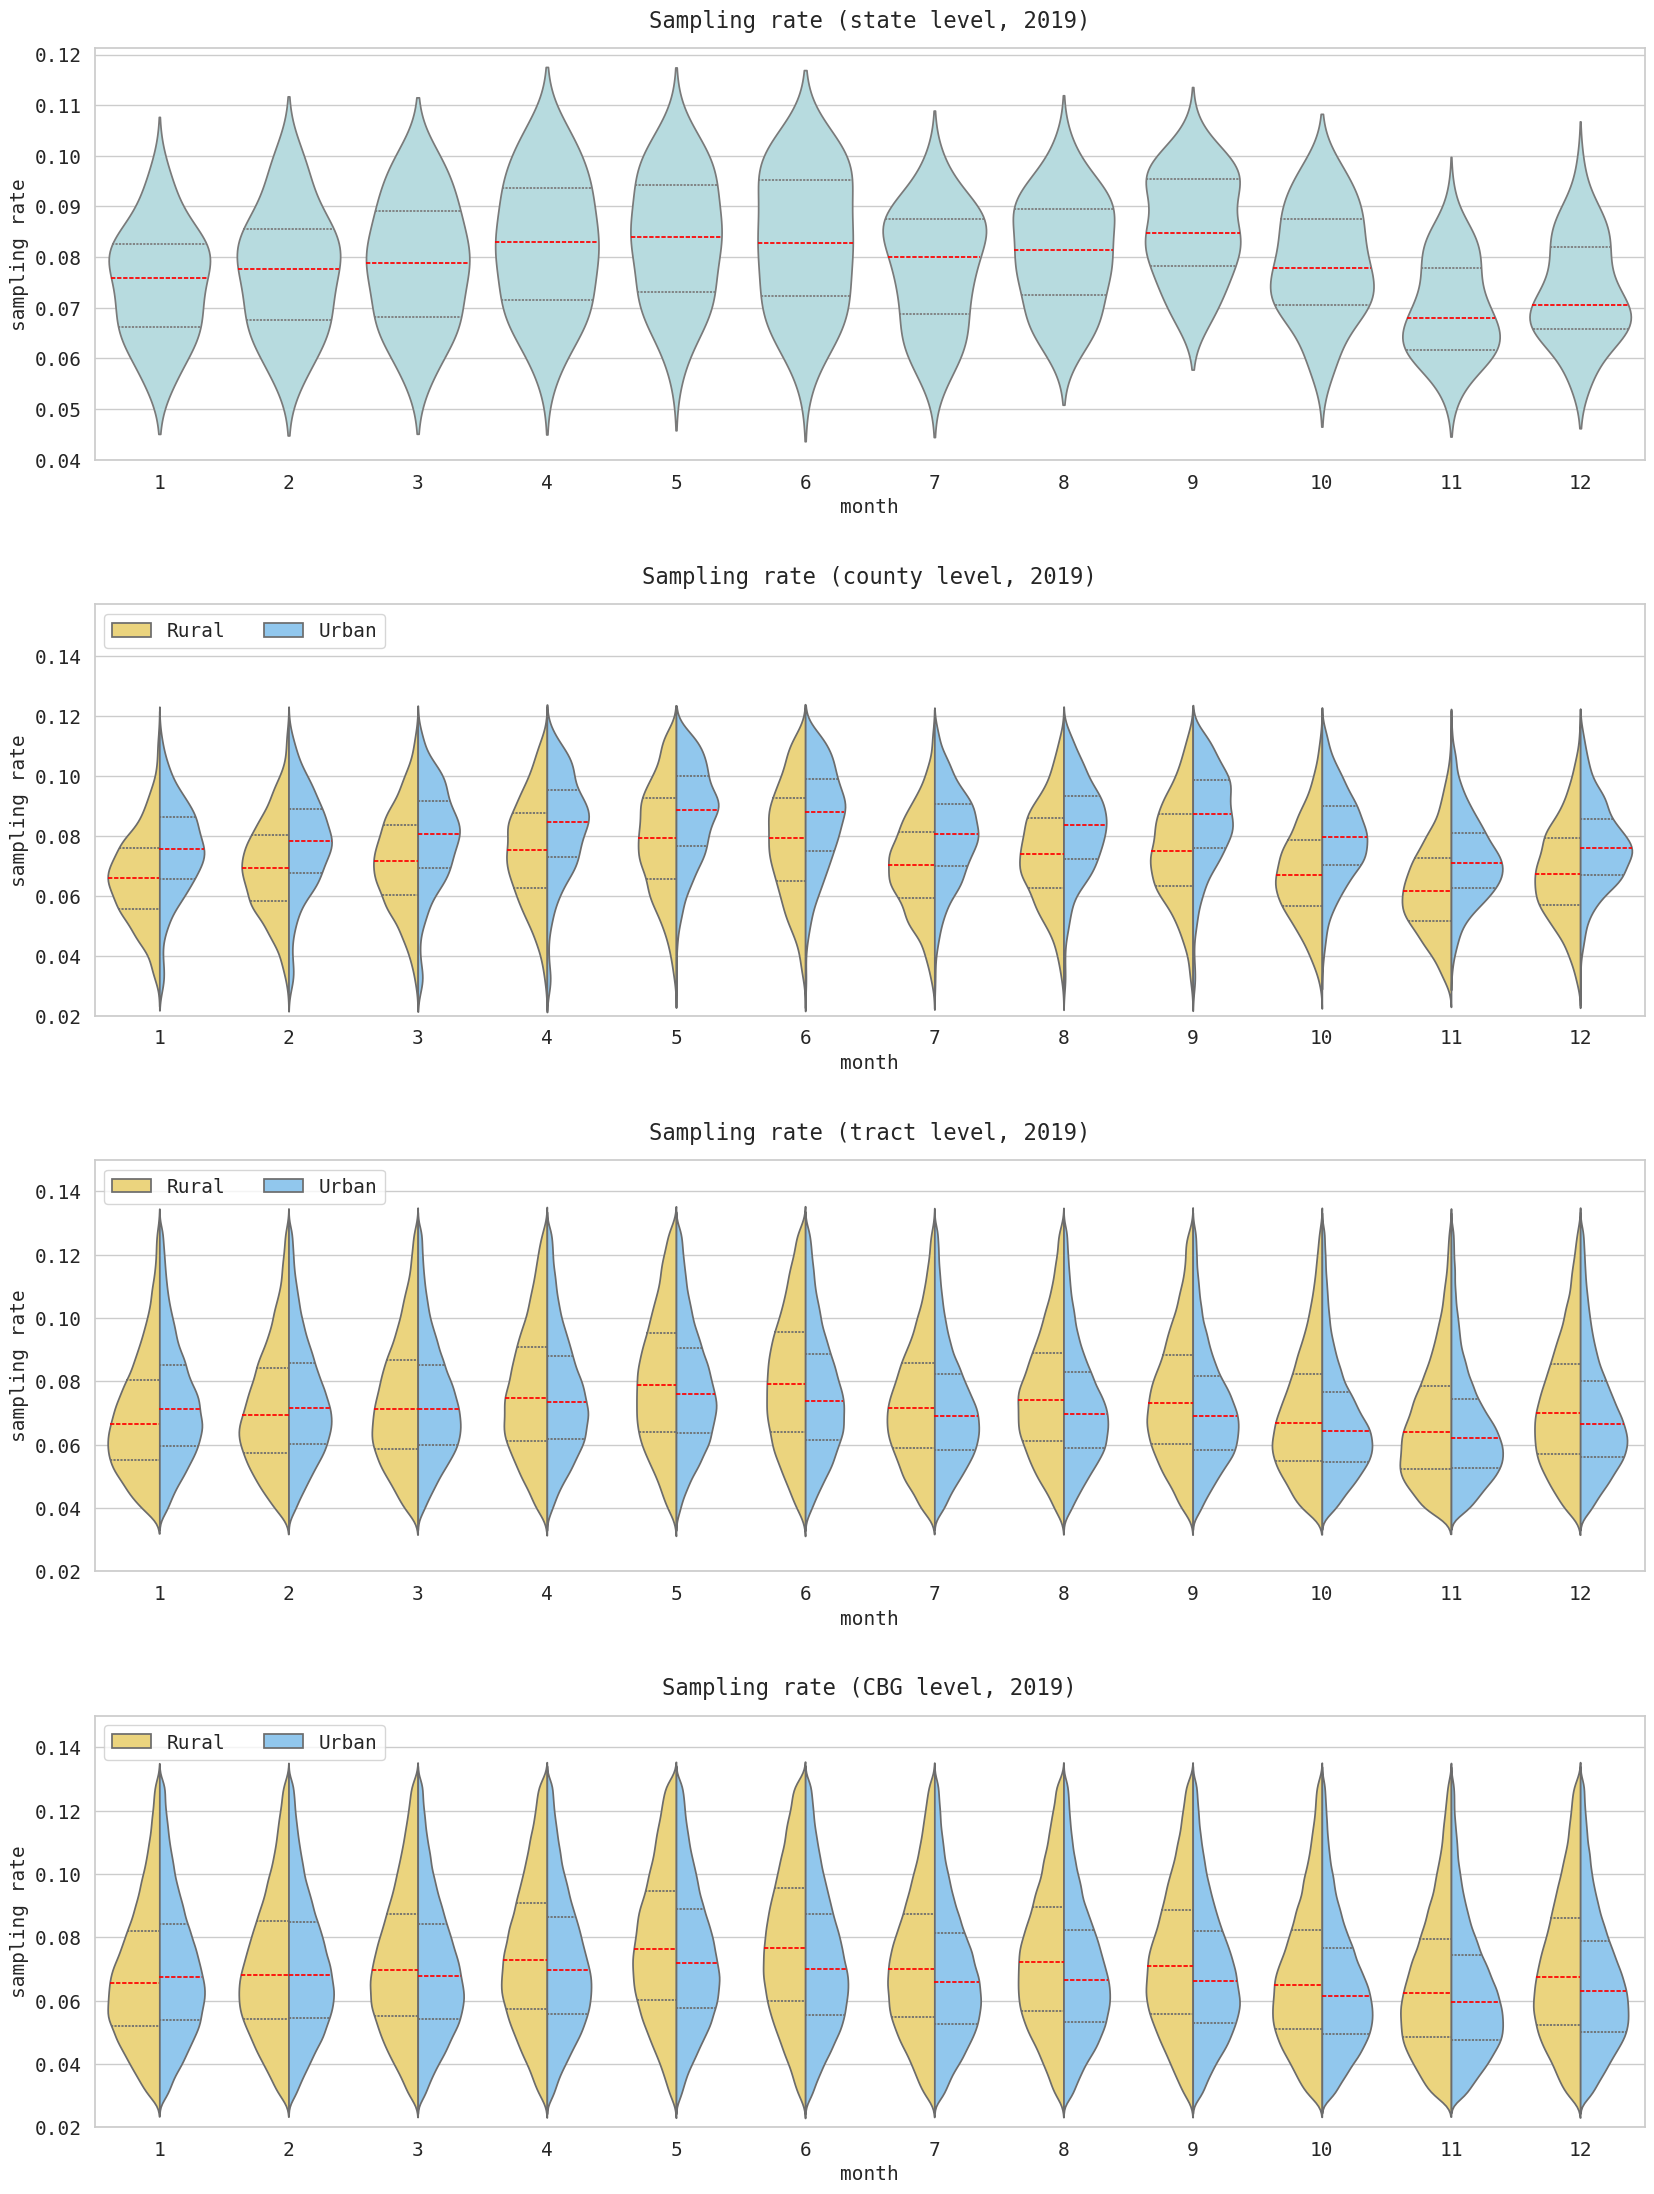

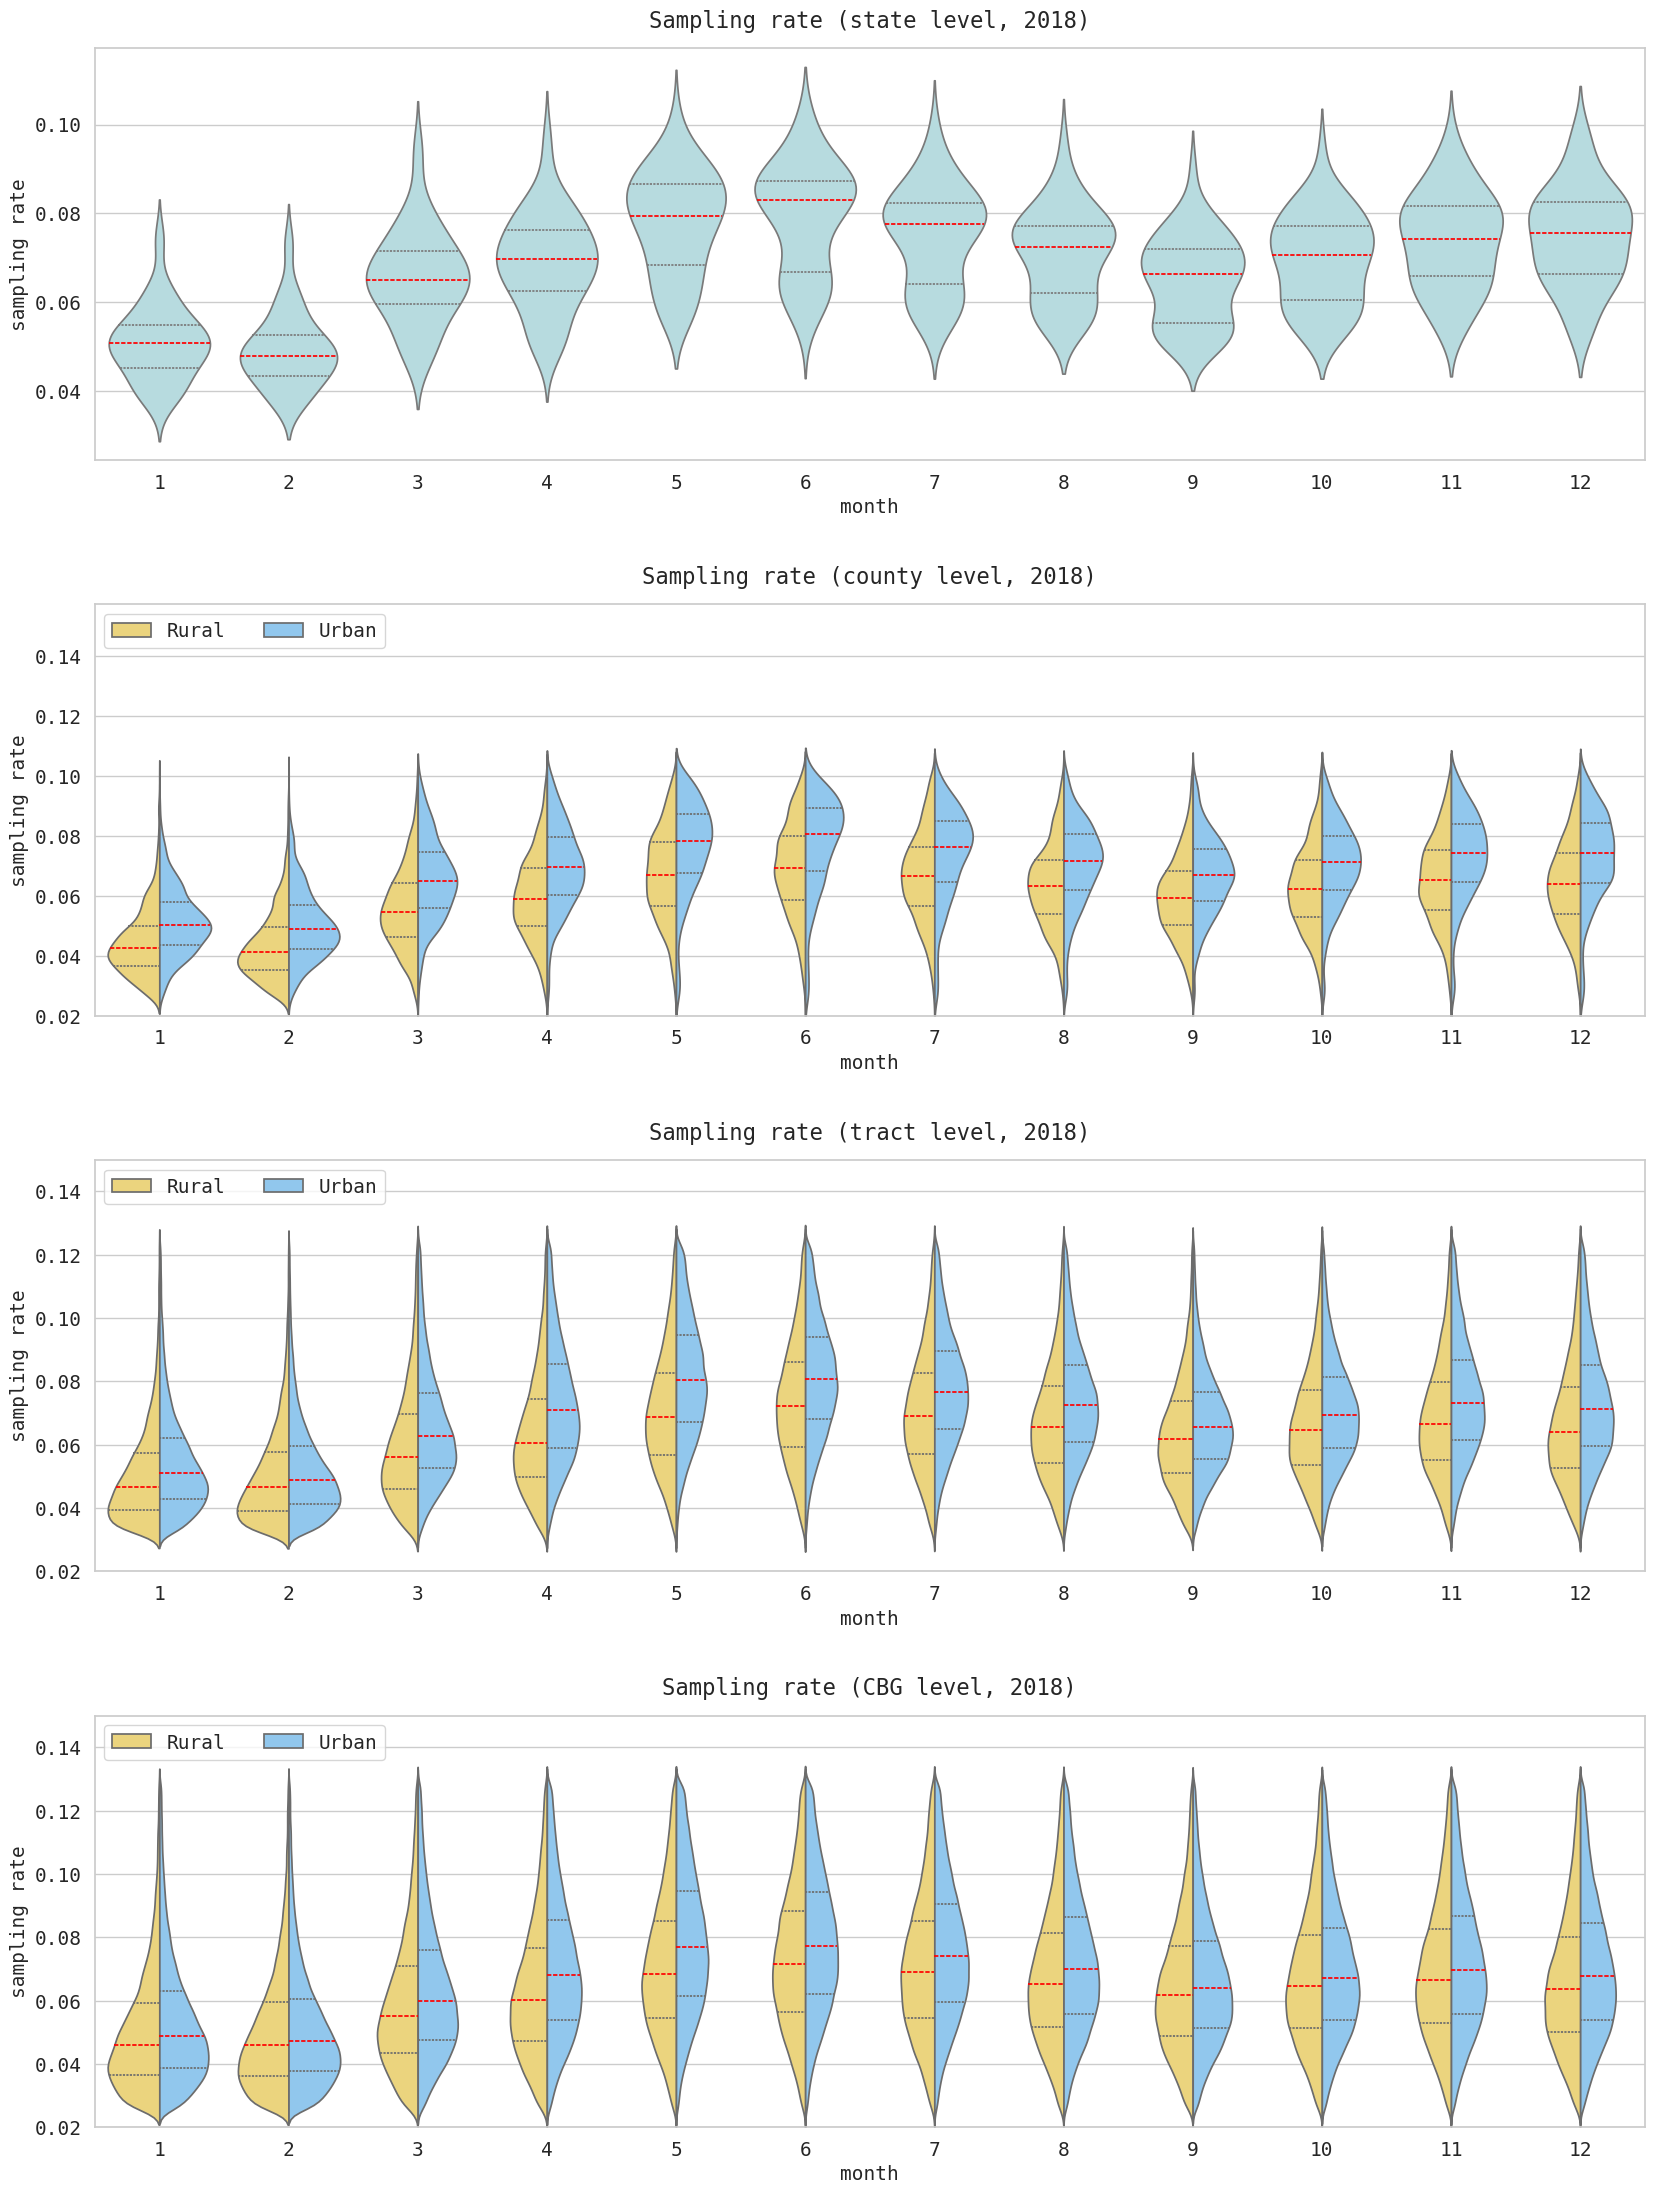

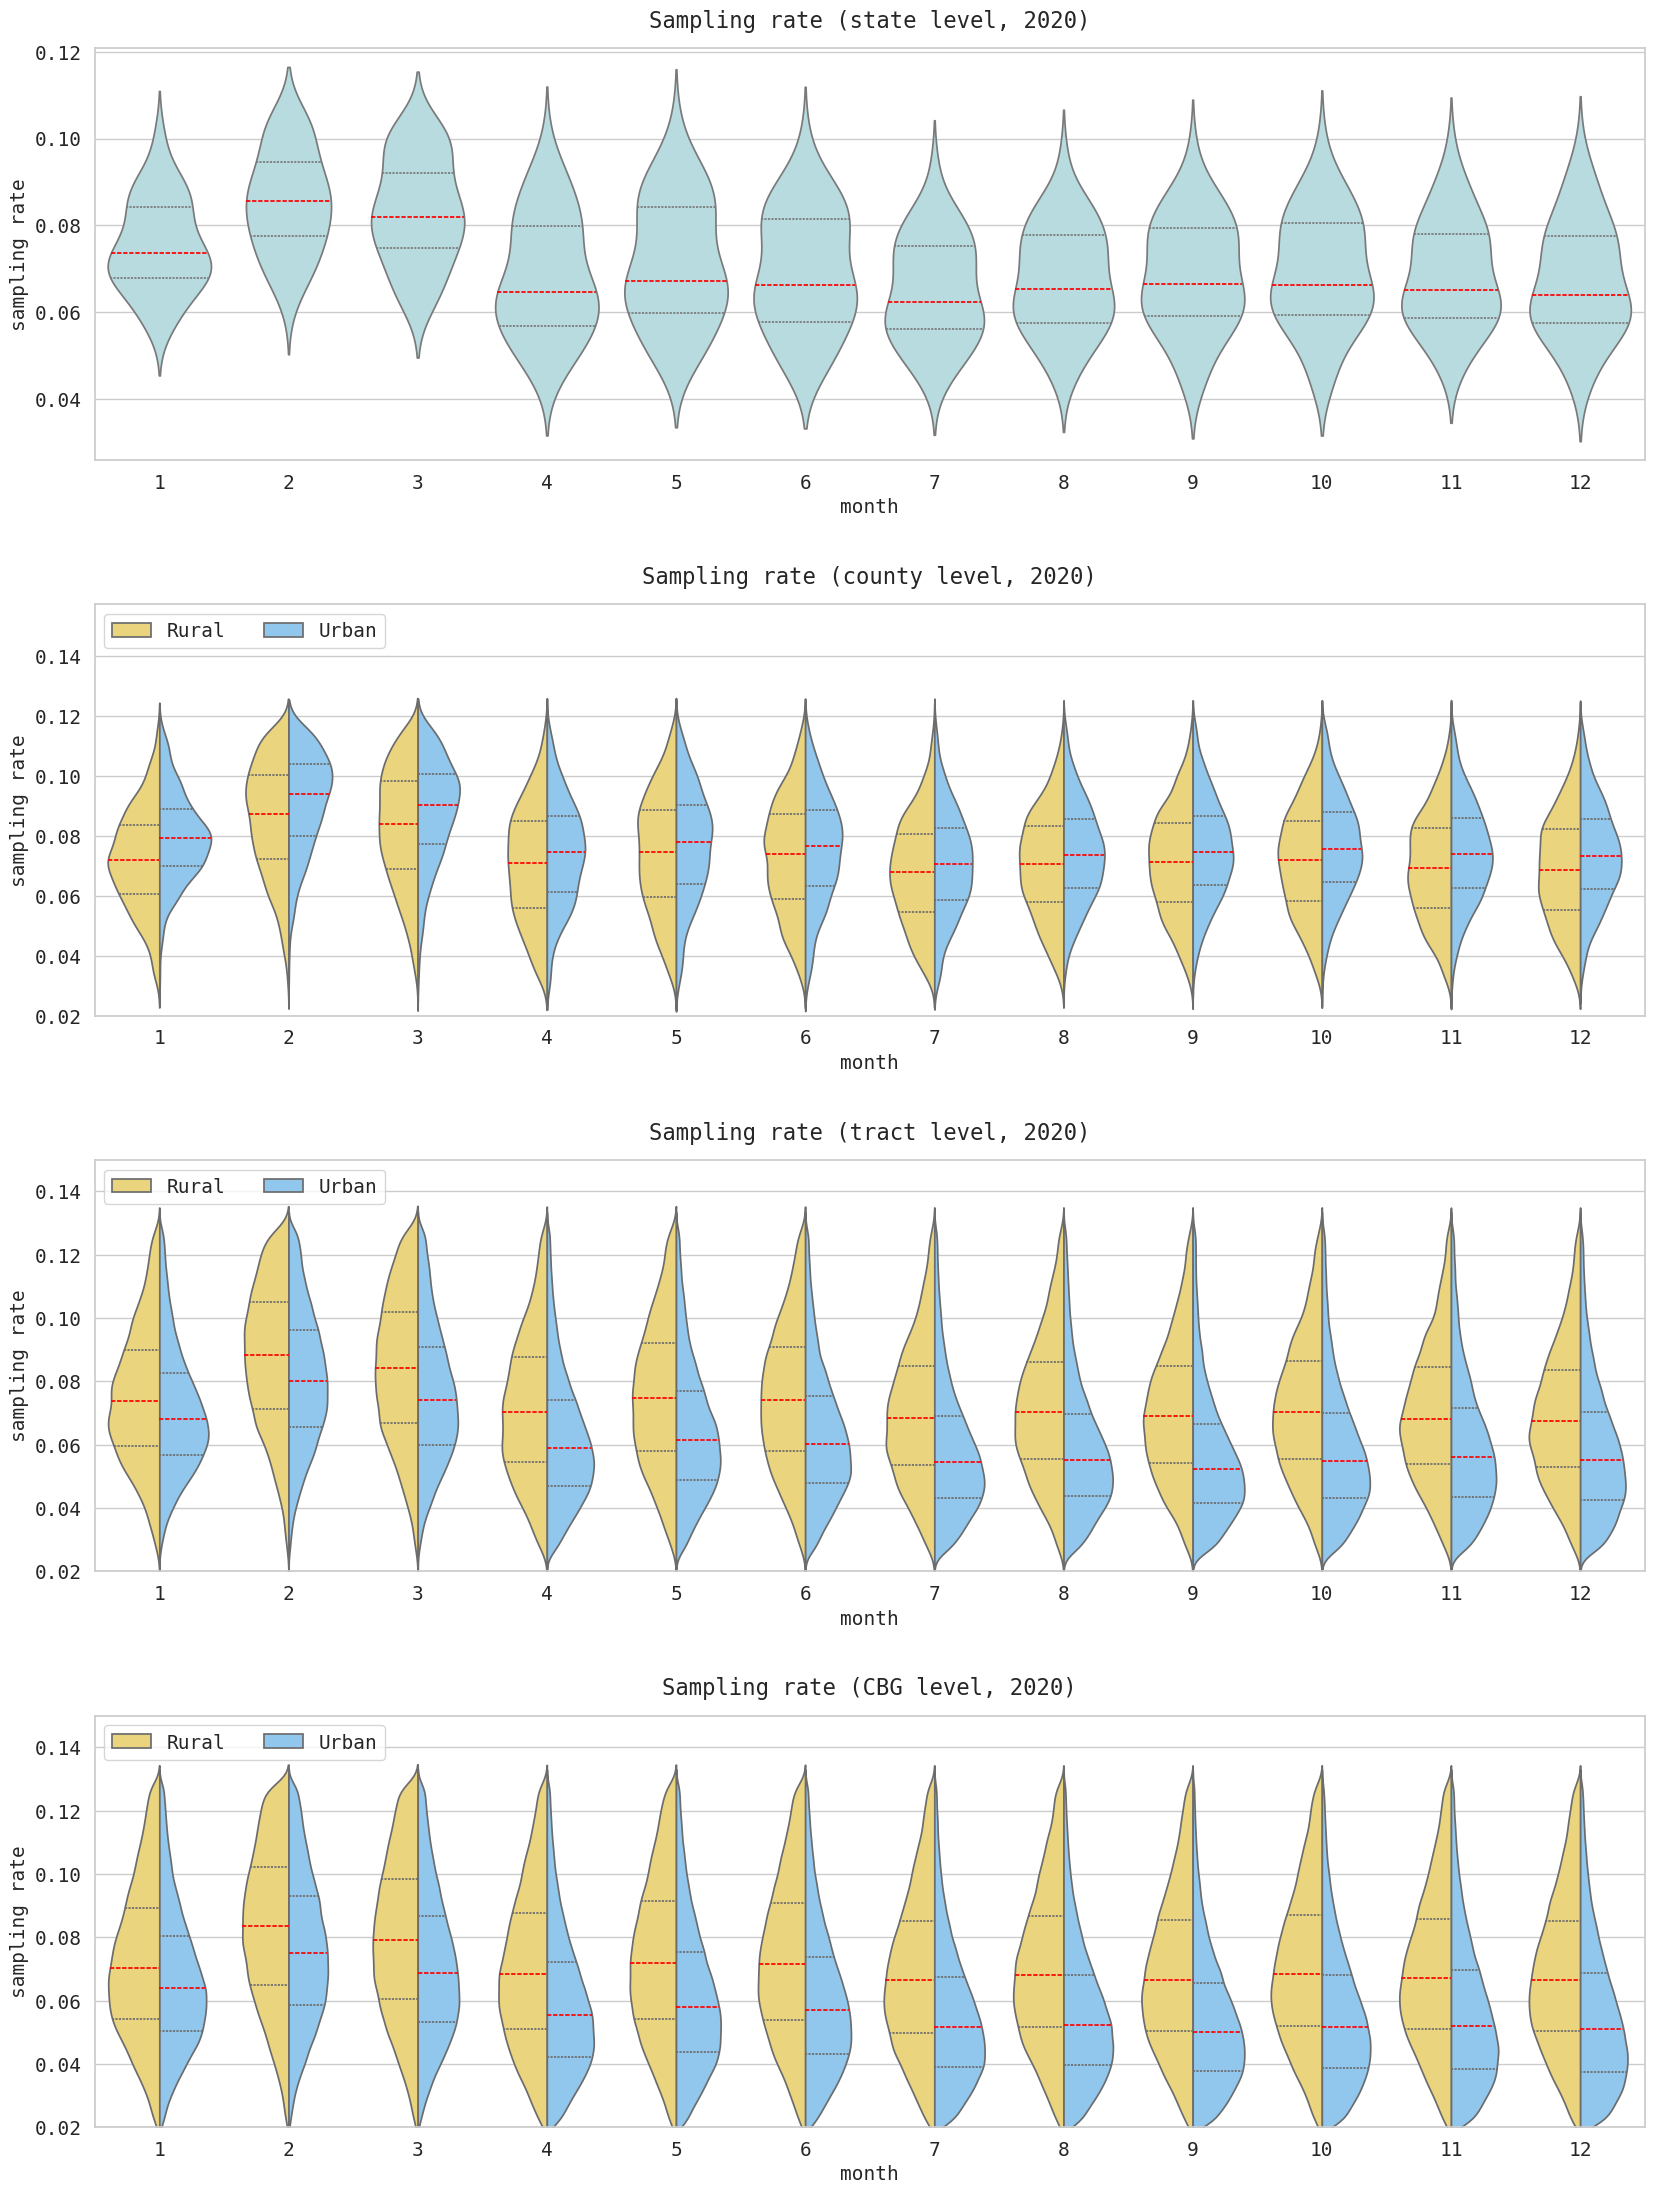

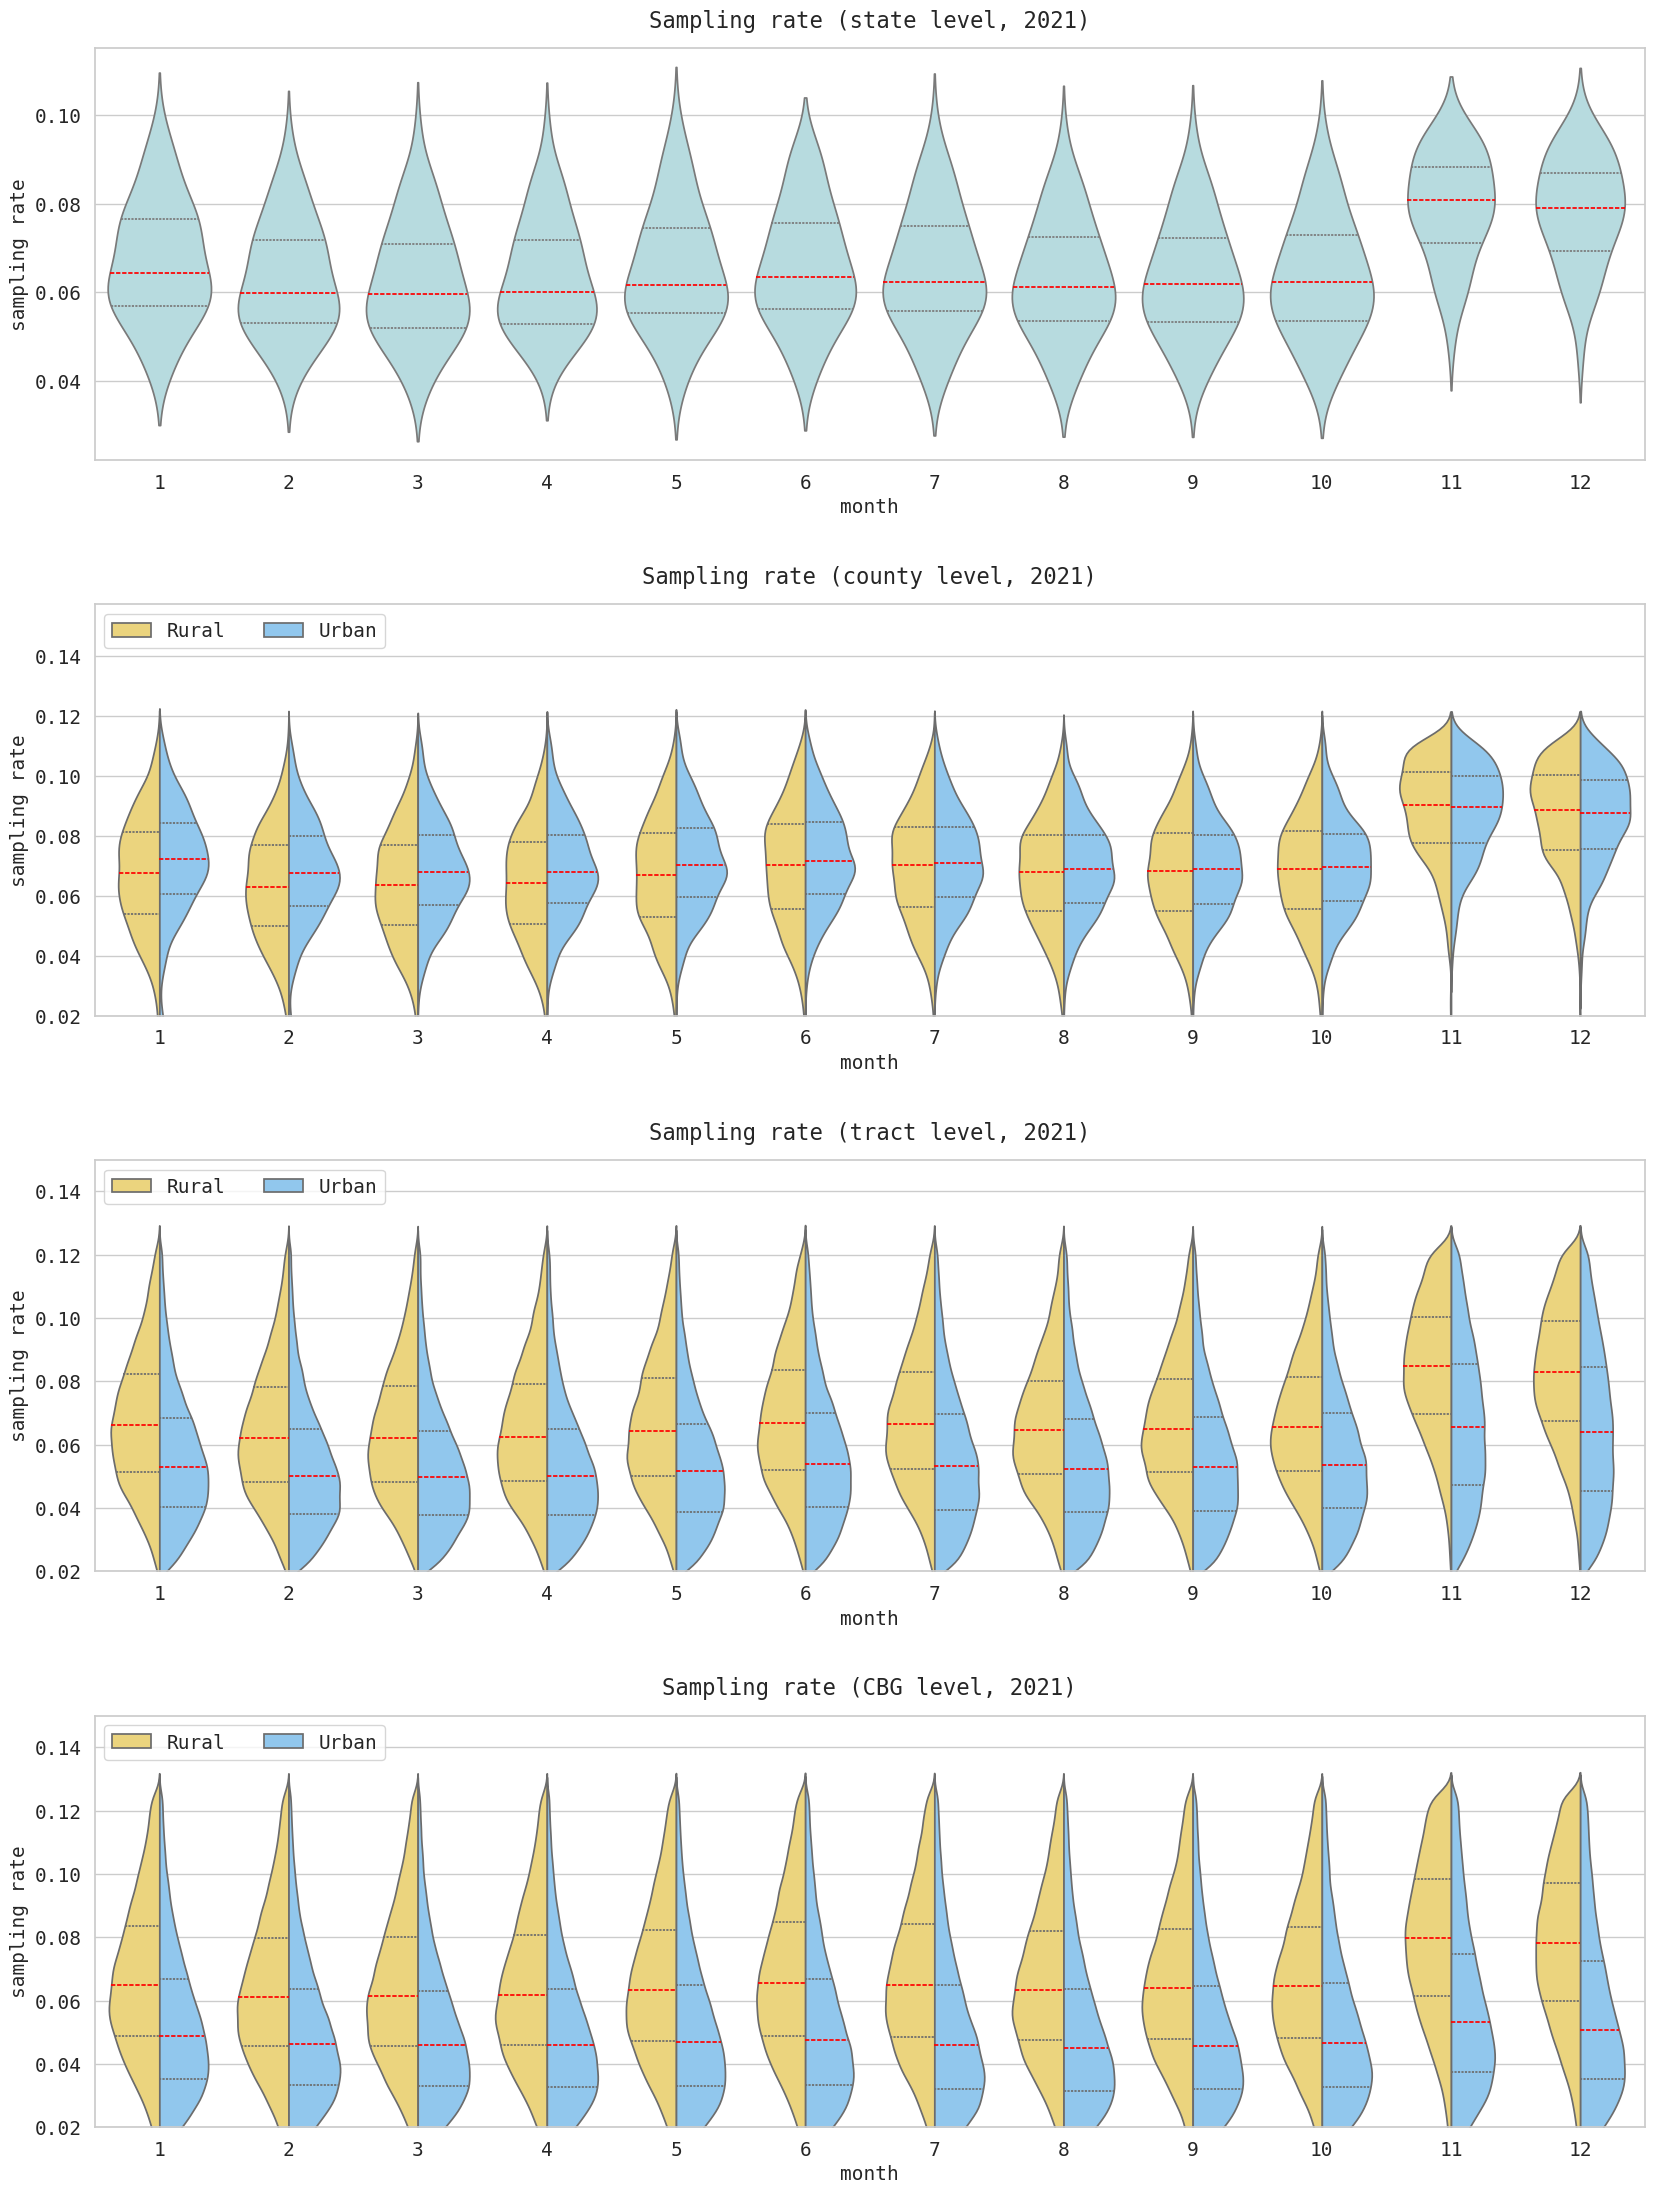

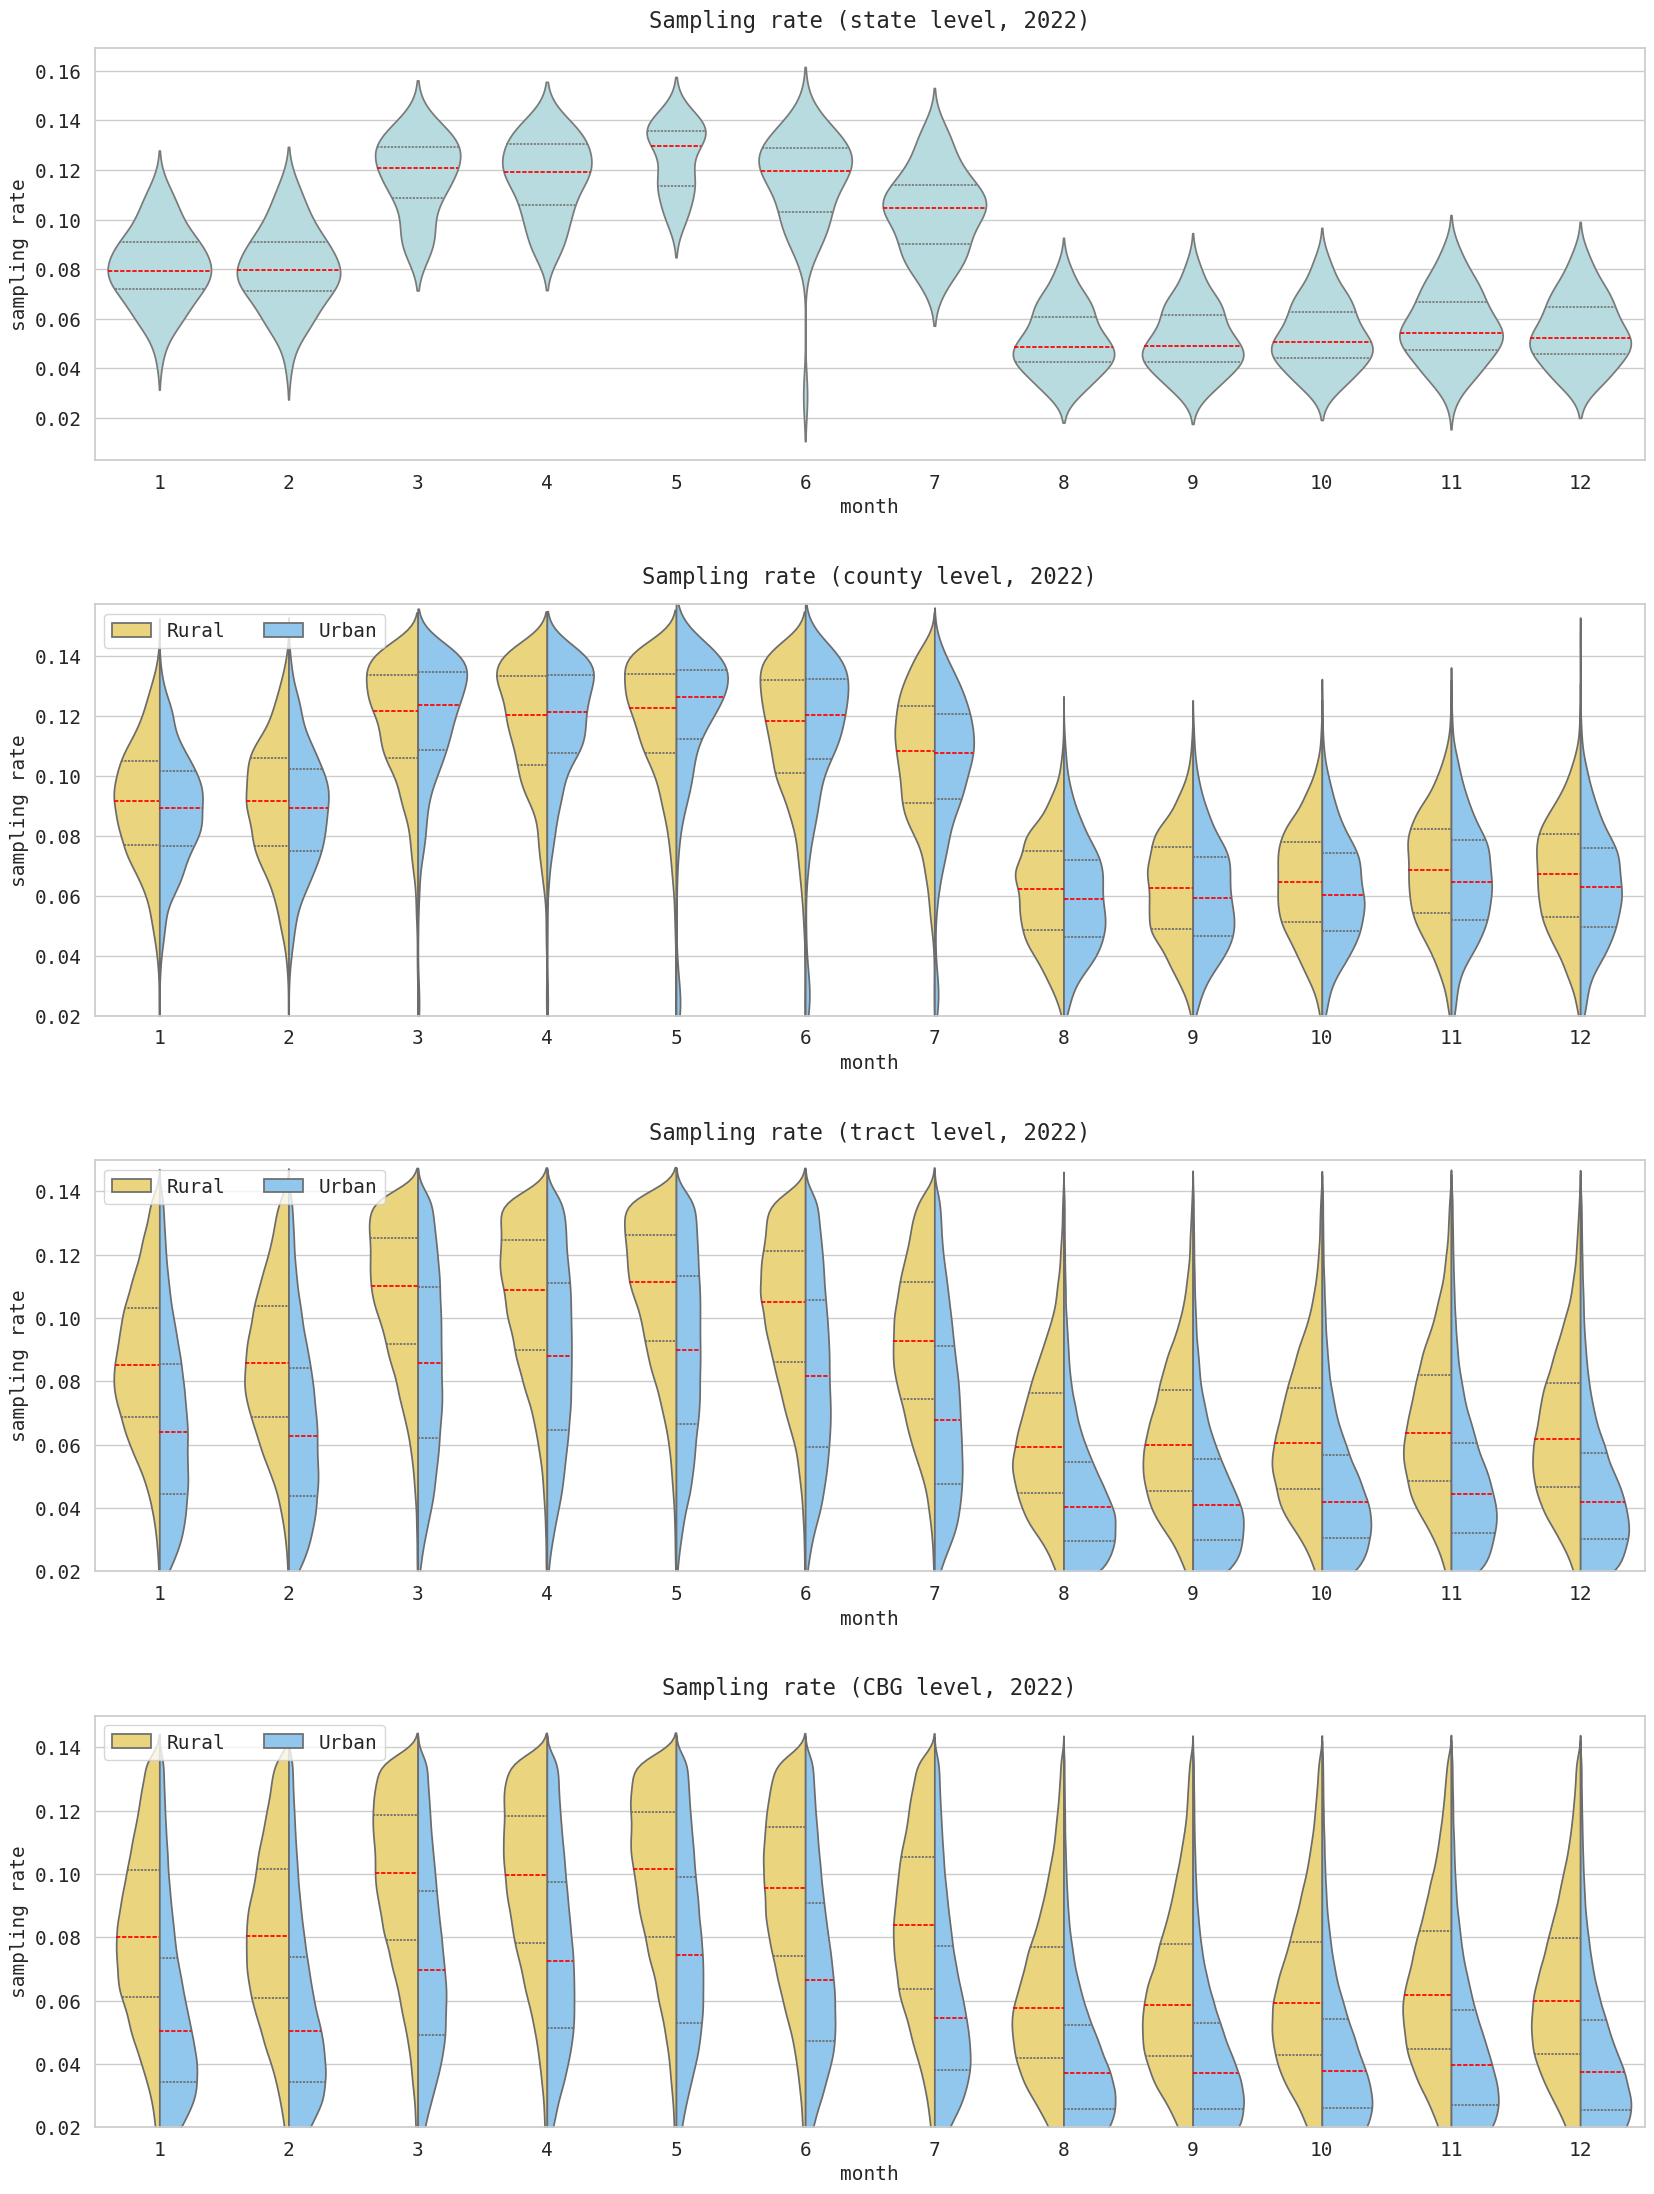

In [20]:
import warnings

# Filter out warnings with category 'FutureWarning'
warnings.simplefilter(action='ignore', category=FutureWarning)

def sampling_rate_monthly_violin(df, urban_df_dict, year):    
    
    
    plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
    plt.rc('legend', fontsize=14)    # legend fontsize
    plt.rcParams['font.family'] = 'monospace'  
    plt.rcParams['axes.labelsize'] = 14
    
    levels =  ['state', 'county', 'tract', 'CBG']
    

    
    fig, axs = plt.subplots(nrows=len(levels), ncols=1, figsize=(20, 27), facecolor='white')
    
    for idx, level in enumerate(levels): 
    # for level in['county', 'tract', 'CBG', 'state']:
    
        ax = axs[idx]
        
        print(idx)
        
        if level == 'state':
            # print("df.columns:", df.columns)
            level_df = df.copy().query(f"fips_level == '{level}' and sampling_rate < 0.15  and sampling_rate > 0")
        
        else: #  level == 'county':
            urban_df = urban_df_dict[level]
            merged_df = df.merge(urban_df, left_on='fips', right_on='FIPS')  # , how='left'
            level_df = merged_df.query(f"fips_level == '{level}' and sampling_rate < 0.15  and sampling_rate > 0")
            
        # clean data
        CLEAN_DATA = True
        if CLEAN_DATA:
            level_df = level_df.copy().query(f" sampling_rate <  sampling_rate.quantile(.975)")
            level_df = level_df.copy().query(f" sampling_rate >  sampling_rate.quantile(.025)")
 
        level_df['month'] = level_df.copy()['end_date'].astype(str).str[-2:]
        level_df['month'] = level_df.copy()['month'].astype(int)

        # return level_df

        print("Level:", level, "len of level_df:", len(level_df))
         
        if level == 'state':
            sb.violinplot(y="sampling_rate", x="month", #hue="Urban",
                           inner="quart", split=False, color='powderblue',
                          scale='count',
                          ax=ax,
                        # split=True, inner="quart", color='white',
                        # palette={"Yes": "#2AEFF3", "No": "#F6D051"},                         
                        data=level_df)

        else:
            # continue
            level_df['Urban'] = level_df['Urban'].copy().replace({'No': 'Rural', 'Yes': 'Urban'})
            # return level_df
            sb.violinplot(y="sampling_rate", x="month", hue="Urban",
                        split=True, inner="quart", #color='0.8',
                          # cut=0, 
                          ax=ax,
                         # scale='count',
                          hue_order  = ['Rural', 'Urban'],
                        palette={"Urban": "#82cafc", "Rural": "#fdde6c"},  # powderblue  limegreen sunflower:#FFC512 azure:#069af3  
                          # sky:#82cafc   wheat  pale gold:#fdde6c
                        data=level_df) 
            ax.legend(loc='upper left', ncol=2)
            ax.set_ylim((0.02, 0.15))
            
        if level == 'county':
            ax.set_ylim((0.02, ax.get_ylim()[1]*1.05))
            
        
        ax.set_title(f'Sampling rate ({level} level, {year})', y=1.03, fontsize=16)
        ax.set_ylabel("sampling rate")

        for line in ax.lines[1::3]:
            line.set_color("red")
            
    plt.subplots_adjust(hspace=0.35)
    new_name = os.path.join(save_dir, f"Sampling_rate_urban_violin_{year}.png")        
    plt.savefig(new_name, dpi=300, bbox_inches='tight', pad_inches=0.2)
        
        # break

        

            
for year, df in data_dict.items():
    print(year, f'len of df:', len(df))
    level_df = sampling_rate_monthly_violin(df, urban_df_dict, year)
    # break